# Training and testiong a ANN for the Titanic dataset

## Importing required libraries

In [397]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

In [398]:
%run ../ml_infra/infra.ipynb

## Defining constants

In [399]:
class ImputationMethod:
    FREQUENT_CATEGORY = 'FrequentCategory'
    MISSING_CATEGORY = 'MissingCategory'
    KNN = 'KNN'

class TicketFeatures:
    TICKET = 'Ticket'
    TICKET_PARSED = 'TicketParsed'
    TICKET_NUMBER = 'TicketNumber'
    TICKET_NUMBER_BINNED = 'TicketNumberBinned'
    TICKET_PREFIX = 'TicketPrefix'
    TICKET_LABEL = 'ticket_label'

class CabinFeatures:
    CABIN = 'Cabin'
    CABIN_PARSED = 'CabinParsed'
    CABIN_NUMBER = 'CabinNumber'
    CABIN_NUMBER_BINNED = 'CabinNumberBinned'
    DECK_CODE = 'DeckCode'
    CABIN_LABEL = 'cabin_label'

class ImputationConstants:
    CABIN_NUMBER_IMPUTATION_VALUE = 999
    
target_name = 'survived'
    
features = ['sex', 'age', 'sib_sp', 'par_ch','embarked', \
            TicketFeatures.TICKET_LABEL, CabinFeatures.CABIN_LABEL, 'deck_code']

num_features = ['age']
cat_features = ['sex', 'sib_sp', 'par_ch','embarked', TicketFeatures.TICKET_LABEL, \
                CabinFeatures.CABIN_LABEL, 'deck_code']

features_to_encode = ['sex', 'embarked', 'deck_code']

feature_to_scale =  ['age', 'sib_sp', 'par_ch' , TicketFeatures.TICKET_LABEL, CabinFeatures.CABIN_LABEL]

binning_quantiles = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

index_name = 'PassengerId'
index_alias = 'pax_id'

column_rename = { 'Survived' : 'survived', 'Pclass' : 'pax_class',  \
                'Sex' : 'sex', 'Age' : 'age', 'SibSp' : 'sib_sp', 'Parch' : 'par_ch', \
                'Embarked' : 'embarked', TicketFeatures.TICKET_NUMBER_BINNED : TicketFeatures.TICKET_LABEL, \
                 CabinFeatures.CABIN_NUMBER_BINNED : CabinFeatures.CABIN_LABEL, \
                'DeckCode' : 'deck_code'}

ann_config = { 
    'hidden_layer_size' : 64, 
    'learning_rate' : .1,
    'epochs' : 300,
    'batch_size' : 64
}

## Loading the Titanic dataset

In [400]:
titanic_df = pd.read_csv('../datasets/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data description

Feature description:

 1. Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.
 2. Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 3. Name - Name
 4. Sex - Sex
 5. Age - Age
 6. Sibsp - Number of Siblings/Spouses Aboard
 7. Parch - Number of Parents/Children Aboard
 8. Ticket - Ticket Number
 9. Fare - Passenger Fare
 10. Cabin - Cabin
 11. Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Data Structures

In [401]:
class Cabin:
    def __init__(self, deck_code, number):
        self.__deck_code = deck_code
        self.__number = number

    def __str__(self):
        return f'Cabin no. {self.__number}, deck code is "{self.__deck_code}"'
        
    @property    
    def deck_code(self):
        return self.__deck_code
    
    @deck_code.setter
    def deck_code(self, value):
        self.__deck_code = value
        
    @property    
    def number(self):
        return self.__number
    
    @number.setter
    def number(self, value):
        self.__number = value
 
    def parse(cabin):
        try:
            assert not (cabin is np.nan) 
            cabin_items = cabin.split(" ")
            
            parsed_cabins = []
            for item in cabin_items:
                parsed_cabin = Cabin.parse_item(item)
                parsed_cabins.append(parsed_cabin)
            
            return parsed_cabins
        except ValueError as e:
            print(f'Unable parse the "{cabin}" cabin. Details: {e}')

    def parse_item(cabin):
        try:
            assert not (cabin is np.nan)
            
            cabin_number = cabin[1 :]
            deck_code = cabin[0]
            
            return Cabin(deck_code, cabin_number)
        except ValueError as e:
            print(f'Unable parse the "{cabin}" cabin ITEM. Details: {e}')

class Ticket:
    def __init__(self, prefix, number):
        self.__prefix = prefix
        self.__number = number

    def __str__(self):
        
        ticket = ''
        if(not self.__prefix is np.nan):
            ticket = self.__prefix
        
        return f'Ticket {ticket} {self.__number} no. {self.__number}'
        
    @property    
    def prefix(self):
        return self.__prefix
    
    @prefix.setter
    def prefix(self, value):
        self.__prefix = value
        
    @property    
    def number(self):
        return self.__number
    
    @number.setter
    def number(self, value):
        self.__number = value
            
    def parse(ticket):
        try:
            ticket_number = np.nan
            ticket_prefix = np.nan
            ticket_splited = ticket.split(" ")
    
            if (ticket == 'LINE'):
                ticket_prefix = ticket
            elif (len(ticket_splited) == 1):
                ticket_number = int(ticket_splited[0])
            elif (len(ticket_splited) == 2):
                ticket_number = int(ticket_splited[1])
                ticket_prefix = str(ticket_splited[0])
            elif (len(ticket_splited) == 3):
                ticket_number = int(ticket_splited[2])
                ticket_prefix = f'{ticket_splited[0]} {ticket_splited[1]}'
            else:
                raise Exception(f'Unsupported ticket format.')
                
            return Ticket(ticket_prefix, ticket_number)
        except ValueError as e:
            print(f'Unable parse the "{ticket}" ticket. Details: {e}')

## Untility

In [402]:
class FeatureImputer:
     
    def __init__(self):
        self.__instances = {
            ImputationMethod.FREQUENT_CATEGORY : CategoricalImputer(imputation_method='frequent'),
            ImputationMethod.MISSING_CATEGORY : CategoricalImputer(imputation_method='missing'),
            ImputationMethod.KNN : KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
        }
    
    def transform(self, imputation_method, df):
        imputer = self.__instances[imputation_method];
        return imputer.transform(df)
    
    def fit_transform(self, imputation_method, x_train, x_test, variables):
        imputer = self.__instances[imputation_method];
        imputer.fit(x_train.loc[:, variables])
        
        x_train_imputed = x_train.copy()       
        train_result = imputer.transform(x_train.loc[:, variables])
        
        x_test_imputed = x_test.copy()
        test_result =  imputer.transform(x_test.loc[:, variables])
        
        if(imputation_method == ImputationMethod.KNN):
            temp_df = pd.DataFrame(train_result, columns=variables)
            temp_df.index = x_train_imputed.index
            x_train_imputed.loc[:, variables] = temp_df[variables]
            
            temp_df = pd.DataFrame(test_result, columns=variables)
            temp_df.index = x_test_imputed.index
            x_test_imputed.loc[:, variables] = temp_df[variables]
        else:
            x_train_imputed.loc[:, variables] = train_result
            x_test_imputed.loc[:, variables] = test_result
            
        return x_train_imputed, x_test_imputed
        

## Data preparation

In [403]:
#Set PassengerId as an index
titanic_df.set_index(index_name, inplace=True)

### Ticket feature preparation

In [404]:
null_ticket_filter = titanic_df[TicketFeatures.TICKET].isnull()
null_tickets_number = len(titanic_df[TicketFeatures.TICKET].loc[null_ticket_filter])

print(f'NULL tickets number is: {null_tickets_number}')

NULL tickets number is: 0


In [405]:
titanic_df[TicketFeatures.TICKET_PARSED] = titanic_df[TicketFeatures.TICKET].apply(lambda t : Ticket.parse(t))
titanic_df[TicketFeatures.TICKET_PARSED].head()

PassengerId
1             Ticket A/5 21171 no. 21171
2              Ticket PC 17599 no. 17599
3    Ticket STON/O2. 3101282 no. 3101282
4              Ticket  113803 no. 113803
5              Ticket  373450 no. 373450
Name: TicketParsed, dtype: object

In [406]:
#Create Ticket_Number feature
titanic_df[TicketFeatures.TICKET_NUMBER] =  titanic_df[TicketFeatures.TICKET_PARSED].apply(lambda t : t.number)
titanic_df[TicketFeatures.TICKET_NUMBER].head()

PassengerId
1      21171.0
2      17599.0
3    3101282.0
4     113803.0
5     373450.0
Name: TicketNumber, dtype: float64

In [407]:
#Create Ticket_Prefix feature
titanic_df[TicketFeatures.TICKET_PREFIX] =  titanic_df[TicketFeatures.TICKET_PARSED].apply(lambda t : t.prefix)
titanic_df[TicketFeatures.TICKET_PREFIX].head()

PassengerId
1         A/5
2          PC
3    STON/O2.
4         NaN
5         NaN
Name: TicketPrefix, dtype: object

In [408]:
#Printing ticket feature statisitcs
filt = titanic_df[TicketFeatures.TICKET_PREFIX].notnull()
not_null_ticket_prefixes_number = len(titanic_df.loc[filt])

filt = titanic_df[TicketFeatures.TICKET_NUMBER].notnull()
not_null_ticket_numbers_number = len(titanic_df.loc[filt])

print(f'Not NULL ticket prefixes number is: {not_null_ticket_prefixes_number}')
print(f'NULL ticket prefixes number is: {len(titanic_df) - not_null_ticket_prefixes_number}')
print(f'Not NULL ticket numbers number is: {not_null_ticket_numbers_number}')
print(f'NULL ticket numbers number is: {len(titanic_df) - not_null_ticket_numbers_number}')

Not NULL ticket prefixes number is: 230
NULL ticket prefixes number is: 661
Not NULL ticket numbers number is: 887
NULL ticket numbers number is: 4


### Cabin feature preparation

In [409]:
null_cabin_filter = titanic_df[CabinFeatures.CABIN].isnull()
null_cabins_number = len(titanic_df[CabinFeatures.CABIN].loc[null_cabin_filter])

print(f'NULL cabins number is: {null_cabins_number}')

NULL cabins number is: 687


In [410]:
not_null_cabin_filter = titanic_df[CabinFeatures.CABIN].notnull()
titanic_df[CabinFeatures.CABIN_PARSED] = titanic_df.loc[not_null_cabin_filter, CabinFeatures.CABIN] \
    .apply(lambda c : Cabin.parse(c))

titanic_df[CabinFeatures.CABIN_PARSED].head() 

PassengerId
1                                  NaN
2     [Cabin no. 85, deck code is "C"]
3                                  NaN
4    [Cabin no. 123, deck code is "C"]
5                                  NaN
Name: CabinParsed, dtype: object

In [411]:
cabin_parsed_not_null_filter = titanic_df[CabinFeatures.CABIN_PARSED].notnull()
cabin_parsed_not_null = titanic_df.loc[cabin_parsed_not_null_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : len(c)) 

cabin_statistics = cabin_parsed_not_null \
    .groupby(cabin_parsed_not_null.values) \
    .count()

print('Cabin statistics\n')
print(cabin_statistics)

singe_cabin_percent = round((cabin_statistics.at[1] / cabin_statistics.sum()) * 100, 2)
singe_cabin_percent

print(f'\nSingle cabin percent = {singe_cabin_percent}%')
if(singe_cabin_percent > 85 ):
    print('The majority of passangers ordered a single cabin. Thus multiple cabins can be ignored. Only first cabin will be taken.')

Cabin statistics

1    180
2     16
3      6
4      2
Name: CabinParsed, dtype: int64

Single cabin percent = 88.24%
The majority of passangers ordered a single cabin. Thus multiple cabins can be ignored. Only first cabin will be taken.


In [412]:
null_parsed_cabin_filter = titanic_df[CabinFeatures.CABIN_PARSED].notnull()
titanic_df[CabinFeatures.CABIN_NUMBER] = titanic_df.loc[null_parsed_cabin_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : c[0].number)

titanic_df[CabinFeatures.CABIN_NUMBER].head()

PassengerId
1    NaN
2     85
3    NaN
4    123
5    NaN
Name: CabinNumber, dtype: object

In [413]:
titanic_df[CabinFeatures.DECK_CODE] = titanic_df.loc[null_parsed_cabin_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : c[0].deck_code)

titanic_df[CabinFeatures.DECK_CODE].head()

PassengerId
1    NaN
2      C
3    NaN
4      C
5    NaN
Name: DeckCode, dtype: object

In [414]:
#Arranging ticket numbers into 10 bins, assigning an interval mean for each bin value

titanic_df[TicketFeatures.TICKET_NUMBER_BINNED] = pd \
    .qcut(titanic_df[TicketFeatures.TICKET_NUMBER], q=binning_quantiles) \
    .apply(lambda i : int((i.left + i.right) / 2))

sorted_ticket_numbers = titanic_df[TicketFeatures.TICKET_NUMBER].sort_values().values
sorted_binned_ticket_numbers = titanic_df[TicketFeatures.TICKET_NUMBER_BINNED].sort_values().values

print(f'Arranging ticket numbers into {len(binning_quantiles)} bins, assigning an interval mean for each bin value')

titanic_df[TicketFeatures.TICKET_NUMBER_BINNED]

Arranging ticket numbers into 11 bins, assigning an interval mean for each bin value


PassengerId
1        23326
2        23326
3      1735770
4       176065
5      1735770
        ...   
887     176065
888      70670
889       7178
890      70670
891    1735770
Name: TicketNumberBinned, Length: 891, dtype: category
Categories (10, int64): [1337 < 7178 < 14636 < 23326 ... 291773 < 346458 < 359723 < 1735770]

In [415]:
def cabin_number_to_int(n):
    if (n is np.nan or n == ''):
        return ImputationConstants.CABIN_NUMBER_IMPUTATION_VALUE
    else:
        return int(n)

temp = titanic_df[CabinFeatures.CABIN_NUMBER].apply(cabin_number_to_int)
temp.head()

PassengerId
1    999
2     85
3    999
4    123
5    999
Name: CabinNumber, dtype: int64

In [416]:
#Arranging cabin numbers into 10 bins, assigning an interval mean for each bin value
titanic_df[CabinFeatures.CABIN_NUMBER_BINNED] = pd \
    .qcut(temp, q=binning_quantiles, duplicates='drop') \
    .apply(lambda i : int((i.left + i.right) / 2))

sorted_cabin_numbers = temp.apply(lambda c : str(c)).sort_values().values
sorted_binned_cabin_numbers = titanic_df[CabinFeatures.CABIN_NUMBER_BINNED].apply(lambda c : str(c)).sort_values().values

print(f'Arranging cabin numbers into {len(binning_quantiles)} bins, assigning an interval mean for each bin value')

titanic_df[CabinFeatures.CABIN_NUMBER_BINNED]

Arranging cabin numbers into 11 bins, assigning an interval mean for each bin value


PassengerId
1      551
2       69
3      551
4      551
5      551
      ... 
887    551
888     69
889    551
890    551
891    551
Name: CabinNumberBinned, Length: 891, dtype: category
Categories (3, int64): [18 < 69 < 551]

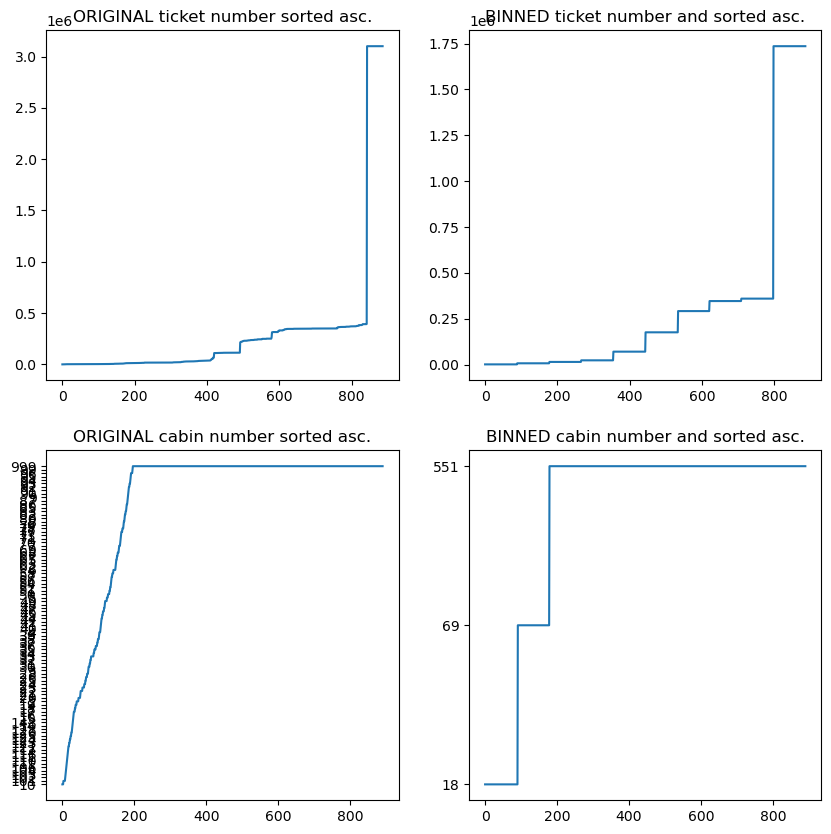

In [417]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

ax[0, 0].plot(sorted_ticket_numbers)
ax[0, 0].title.set_text('ORIGINAL ticket number sorted asc.')

ax[0, 1].plot(sorted_binned_ticket_numbers)
ax[0, 1].title.set_text('BINNED ticket number and sorted asc.')

ax[1, 0].plot(sorted_cabin_numbers)
ax[1, 0].title.set_text('ORIGINAL cabin number sorted asc.')

ax[1, 1].plot(sorted_binned_cabin_numbers)
ax[1, 1].title.set_text('BINNED cabin number and sorted asc.')

plt.show()

In [418]:
titanic_df = titanic_df.rename(columns=column_rename)
titanic_df.index.name = index_alias

## Train and test dataset split

In [419]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic_df[features], 
    titanic_df[target_name], 
    test_size=0.3, 
    random_state=123)

x_train.head()

,sex,age,sib_sp,par_ch,embarked,ticket_label,cabin_label,deck_code
pax_id,,,,,,,,
417,female,34.0,1,1,S,23326,551,NaN
802,female,31.0,1,1,S,70670,551,NaN
513,male,36.0,0,0,S,14636,18,E
456,male,29.0,0,0,C,359723,551,NaN
758,male,18.0,0,0,S,70670,551,NaN


## Feature imputation

### Categorical feature imputation

In [420]:
cat_features_imputation_stats = x_train[cat_features].isnull().mean().sort_values(ascending=False)
cat_features_simple_impute = cat_features_imputation_stats[lambda x : ((x > 0) & (x < 0.1))]
cat_features_no_impute = cat_features_imputation_stats[lambda x : x == 0]
cat_features_complex_impute = cat_features_imputation_stats[lambda x : x > 0.1]

print(f'Simple imptation required for the {cat_features_simple_impute.index.values} features')
print(f'Complex imptation required for the {cat_features_complex_impute.index.values} features')

Simple imptation required for the ['ticket_label' 'embarked'] features
Complex imptation required for the ['deck_code'] features


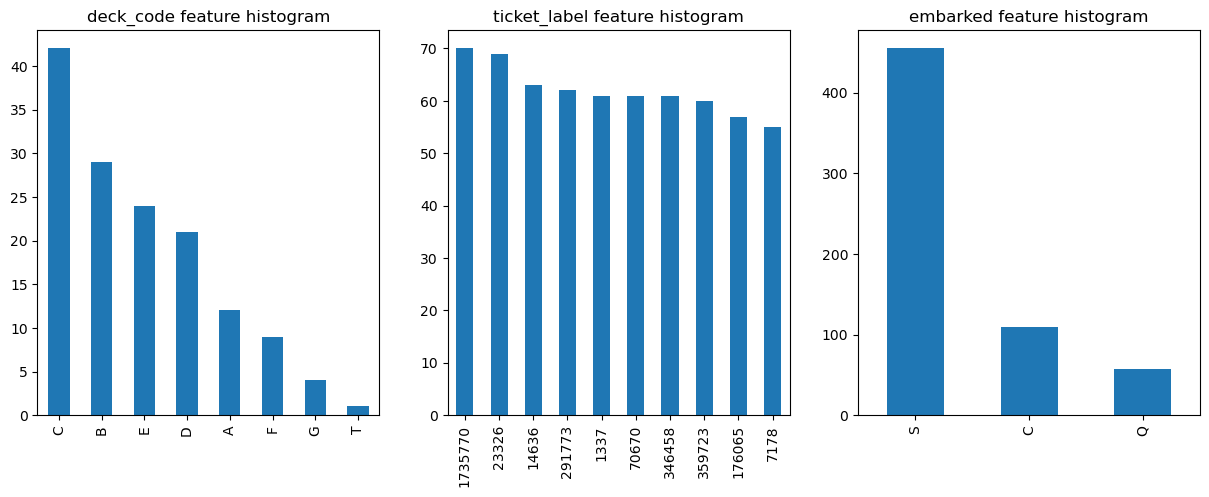

In [421]:
#Categorical feature to impute,probability distribution analysis

def plot_categorical_feature_hist(df, features):
    fig, axis = plt.subplots(1, len(features))
    fig.set_size_inches(15, 5)

    i = 0
    for feature_name in features:
        data = df[feature_name].value_counts()

        data.plot(ax=axis[i], kind='bar')
        axis[i].title.set_text(f'{feature_name} feature histogram')
        i = i + 1
    
    plt.show()

cat_features_to_impute = cat_features_imputation_stats[lambda x : x > 0]
plot_categorical_feature_hist(x_train, cat_features_to_impute.index.values)
#Seems that all distributions are skewed

In [422]:
#Imputing categorical features with low missing value percent
labels = cat_features_simple_impute.index.values

imputer = FeatureImputer()

imputation_method = ImputationMethod.FREQUENT_CATEGORY
x_train_imputed, x_test_imputed = imputer.fit_transform(imputation_method, x_train, x_test, labels)

x_train_imputed.head()

,sex,age,sib_sp,par_ch,embarked,ticket_label,cabin_label,deck_code
pax_id,,,,,,,,
417,female,34.0,1,1,S,23326,551,NaN
802,female,31.0,1,1,S,70670,551,NaN
513,male,36.0,0,0,S,14636,18,E
456,male,29.0,0,0,C,359723,551,NaN
758,male,18.0,0,0,S,70670,551,NaN


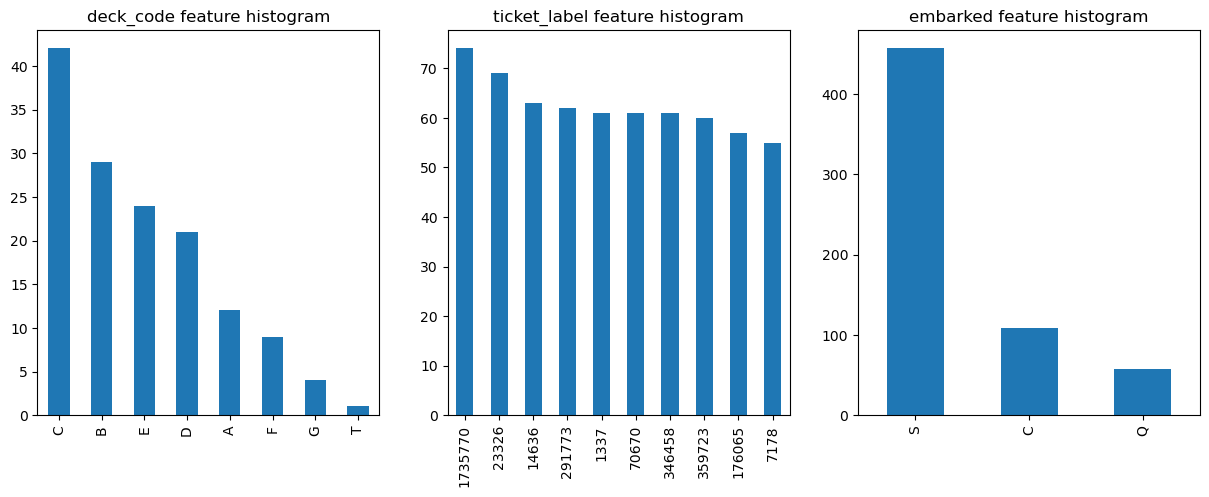

In [423]:
# Data distribution after imputing categorical features with low missing value percent 
plot_categorical_feature_hist(x_train_imputed, cat_features_to_impute.index.values)

In [424]:
#Imputing categorical features with hight missing value percent
labels = cat_features_complex_impute.index.values

imputation_method = ImputationMethod.MISSING_CATEGORY
x_train_imputed, x_test_imputed = imputer.fit_transform(imputation_method, x_train_imputed, x_test_imputed, labels)

x_train_imputed.head()

,sex,age,sib_sp,par_ch,embarked,ticket_label,cabin_label,deck_code
pax_id,,,,,,,,
417,female,34.0,1,1,S,23326,551,Missing
802,female,31.0,1,1,S,70670,551,Missing
513,male,36.0,0,0,S,14636,18,E
456,male,29.0,0,0,C,359723,551,Missing
758,male,18.0,0,0,S,70670,551,Missing


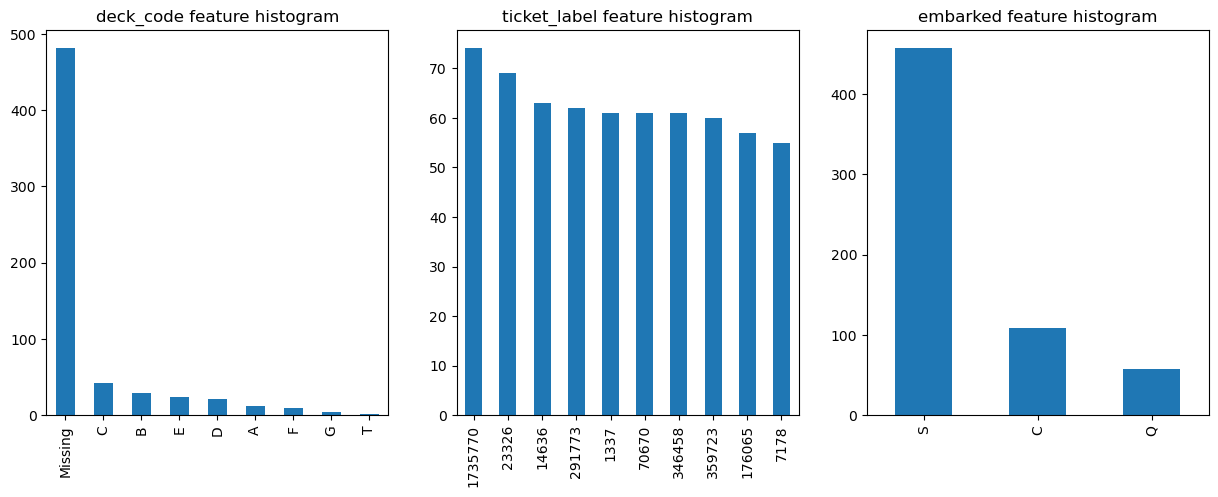

In [425]:
# Data distribution after imputing categorical features with high missing value percent 
plot_categorical_feature_hist(x_train_imputed, cat_features_to_impute.index.values)

## Numerical feature imputation

In [426]:
num_features_imputation_stats = x_train[num_features].isnull().mean().sort_values(ascending=False)
num_features_impute = num_features_imputation_stats[lambda x : ((x > 0) & (x < 0.25))]
num_features_impute

age    0.210273
dtype: float64

In [427]:
#Imputing numerical features with medium missing value percent
labels = num_features_impute.index.values

imputation_method = ImputationMethod.KNN
x_train_imputed, x_test_imputed = imputer.fit_transform(imputation_method, x_train_imputed, x_test_imputed, labels)

x_train_imputed.head()

,sex,age,sib_sp,par_ch,embarked,ticket_label,cabin_label,deck_code
pax_id,,,,,,,,
417,female,34.0,1,1,S,23326,551,Missing
802,female,31.0,1,1,S,70670,551,Missing
513,male,36.0,0,0,S,14636,18,E
456,male,29.0,0,0,C,359723,551,Missing
758,male,18.0,0,0,S,70670,551,Missing


## Categorical feature encoding

In [428]:
encoder = OneHotEncoder(variables=features_to_encode, drop_last=True)

encoder.fit(x_train_imputed)
x_train_encoded = encoder.transform(x_train_imputed)
x_test_encoded = encoder.transform(x_test_imputed)

x_train_encoded.head()

,age,sib_sp,par_ch,ticket_label,cabin_label,sex_female,embarked_S,embarked_C,deck_code_Missing,deck_code_E,deck_code_D,deck_code_B,deck_code_F,deck_code_C,deck_code_A,deck_code_G
pax_id,,,,,,,,,,,,,,,,
417,34.0,1,1,23326,551,1,1,0,1,0,0,0,0,0,0,0
802,31.0,1,1,70670,551,1,1,0,1,0,0,0,0,0,0,0
513,36.0,0,0,14636,18,0,1,0,0,1,0,0,0,0,0,0
456,29.0,0,0,359723,551,0,0,1,1,0,0,0,0,0,0,0
758,18.0,0,0,70670,551,0,1,0,1,0,0,0,0,0,0,0


## Feature scalling

In [429]:
scaller = MinMaxScaler()

scaller.fit(x_train_encoded[feature_to_scale])


x_train_scalled = x_train_encoded.copy()
scalled_df = scaller.transform(x_train_encoded[feature_to_scale])
x_train_scalled[feature_to_scale] = pd.DataFrame(scalled_df, columns=feature_to_scale).values

x_test_scalled = x_test_encoded.copy()
scalled_df = scaller.transform(x_test_encoded[feature_to_scale])
x_test_scalled[feature_to_scale] = pd.DataFrame(scalled_df, columns=feature_to_scale).values

x_train_scalled.head()

,age,sib_sp,par_ch,ticket_label,cabin_label,sex_female,embarked_S,embarked_C,deck_code_Missing,deck_code_E,deck_code_D,deck_code_B,deck_code_F,deck_code_C,deck_code_A,deck_code_G
pax_id,,,,,,,,,,,,,,,,
417,0.421965,0.125,0.2,0.012678,1.0,1,1,0,1,0,0,0,0,0,0,0
802,0.384267,0.125,0.2,0.039974,1.0,1,1,0,1,0,0,0,0,0,0,0
513,0.447097,0.000,0.0,0.007668,0.0,0,1,0,0,1,0,0,0,0,0,0
456,0.359135,0.000,0.0,0.206630,1.0,0,0,1,1,0,0,0,0,0,0,0
758,0.220910,0.000,0.0,0.039974,1.0,0,1,0,1,0,0,0,0,0,0,0


## Training ANN model

In [430]:
input_layer_size = len(x_train_scalled.columns)

In [431]:
class TitanicNetTraining:
    
    def __init__(self, config, model, loss_method, optimizer):
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        
        #Initialing ANN
        self.model = model

        #Initializing loss function
        self.loss_method = loss_method

        #Initialing SGD optimizer
        self.optimizer = optimizer
    
    def execute(self, train_df, targets):
        
        targets_df = pd.DataFrame(targets.tolist(), columns=[target_name])
        
        train_tensor = torch.tensor(train_df.values).float()
        targets_tensor = torch.tensor(targets_df.values).float()
        
        print(f'Features tensor size is {train_tensor.size()}')
        print(f'Targets tensor size is {targets_tensor.size()}\n')
        
        train_dataset = TensorDataset(train_tensor,targets_tensor)
        batchsize    = self.batch_size
        train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
        
        losses = torch.zeros(self.epochs)
        for epochi in range(self.epochs):
           
            batchAcc  = []
            batchLoss = []
            
            # loop over training data batches        
            for X, y in train_loader:
                
                #Forward step
                predictions = self.model(X)
            
                #Calculation loss
                loss = self.loss_method(predictions, y)
                batchLoss.append(loss.item())
            
                #Backward step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
             
            losses[epochi] = np.mean(batchLoss)
        predictions = self.model(train_tensor)
        accuracy = 100 * torch.mean(((predictions > .5) == targets_tensor).float())
        
        return losses, predictions, accuracy
        

class TitanicNet(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        
        hidden_layer_size = config['hidden_layer_size']
        
        #Input layer
        self.input = nn.Linear(input_layer_size, hidden_layer_size)
        
        #Hidden layers
        self.hidden = [nn.Linear(hidden_layer_size, hidden_layer_size)]
        
        #Output layer
        self.output = nn.Linear(hidden_layer_size, 1)
    
    def forward(self, x_train):
        
        data = self.input(x_train)
        data = F.relu(data)
        
        for hidden_layer in self.hidden:
            data = hidden_layer(data)
            data = F.relu(data)
        
        data = self.output(data)
        result = torch.sigmoid(data)
        
        return result

Features tensor size is torch.Size([623, 16])
Targets tensor size is torch.Size([623, 1])

Training accuracy is 87.47993469238281


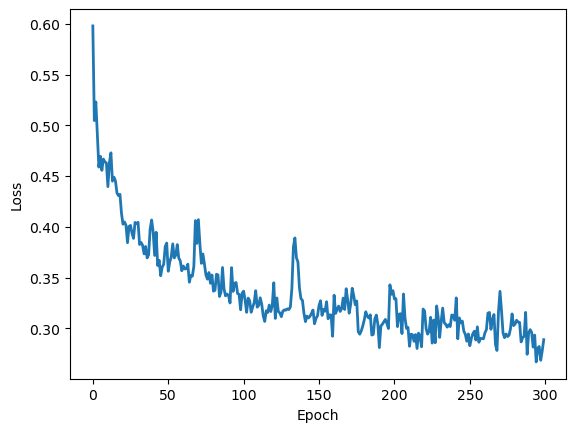

In [432]:
model = TitanicNet(ann_config)
loss_method = nn.BCELoss() #Alternativly use BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=ann_config['learning_rate'])

model_training = TitanicNetTraining(ann_config, model, loss_method, optimizer)

losses, predictions, accuracy = model_training.execute(x_train_scalled, y_train)

print(f'Training accuracy is {accuracy}')
plt.plot(losses.detach(), markerfacecolor='w', linewidth=2)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

## Testing ANN model

In [433]:
targets_df = pd.DataFrame(y_test.tolist(), columns=[target_name])
test_tensor = torch.tensor(x_test_scalled.values).float()
targets_tensor = torch.tensor(targets_df.values).float()

predictions = model(test_tensor)
test_accuracy = 100 * torch.mean(((predictions > .5) == targets_tensor).float())

print(f'Testing accuracy is {test_accuracy}')

Testing accuracy is 81.3432846069336


In [434]:
report = TrainingReport(AccuracyMethods.ACCURACY, LossMethods.BCE)

net_mse = losses.data[losses.size().numel() - 1].item()
net_r2_score = round(test_accuracy.item(), 2)
report.add_record('Neural Network', net_r2_score, net_mse)

In [435]:
report.get()

,algorithm,accuracy,bce_loss
0,Neural Network,81.34,0.288819
